In [59]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import time

## Model Configuration

In [60]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class ModelArgs:
    dim: int = 128
    n_layers: int = 2
    n_heads: int = 4
    n_kv_heads: Optional[int] = 4
    vocab_size: int = -1  # defined later by tokenizer
    multiple_of: int = 256  # make SwiGLU hidden layer size multiple of large power of 2
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5

    max_batch_size: int = 32
    max_seq_len: int = 16 * 8

    epochs: int = 5_000    

model_config = ModelArgs()
print(model_config)

ModelArgs(dim=128, n_layers=2, n_heads=4, n_kv_heads=4, vocab_size=-1, multiple_of=256, ffn_dim_multiplier=None, norm_eps=1e-05, max_batch_size=32, max_seq_len=128, epochs=5000)


## Prepare Data

In [61]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])


lines = open('./data/Shakespeare.txt', 'r').read()
vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}
dataset = torch.tensor(encode(lines), dtype=torch.int8)
print(f'Sentences: {dataset.shape[0]}')

model_config.vocab_size = len(vocab)

def get_batches(data, split, batch_size, context_window):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    if split == 'train':
        batch_data = train
    elif split == 'test':
        batch_data = test
    else:
        batch_data = val

    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

Sentences: 1115394


## Define Models

### RMS Normalization 

- [Paper](https://arxiv.org/pdf/1910.07467.pdf)
- [Reference implementation](https://github.com/facebookresearch/llama/blob/54d44631054deae836aec8ceff92dcf8f20ca9e7/llama/model.py#L34)

In [62]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """
        Initialize the RMSNorm normalization layer.

        Args:
            dim (int): The dimension of the input tensor.
            eps (float, optional): A small value added to the denominator for numerical stability. Default is 1e-6.

        Attributes:
            eps (float): A small value added to the denominator for numerical stability.
            weight (nn.Parameter): Learnable scaling parameter.

        """
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x : torch.tensor) -> torch.tensor:
        """
        Apply the RMSNorm normalization to the input tensor.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The normalized tensor.

        """
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x) -> torch.tensor:
        """
        Forward pass through the RMSNorm layer.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after applying RMSNorm.

        """        
        return self._norm(x.float()).type_as(x) * self.weight

### RoPE

- [Paper](https://arxiv.org/pdf/2104.09864.pdf)
- [Reference Implementation](https://github.com/facebookresearch/llama/blob/dccf644213a2771a81fc4a754eed9623ea7f8444/llama/model.py#L80)

In [63]:
class RoPE:
    def __init__(self, dim: int, max_seq_len: int, theta: float = 10000.0):
        """
        Precompute the frequency tensor for complex exponentials (cis, defined as 'm*theta_i' in the paper) 
        with given dimensions.

        Calculates a frequency tensor with complex exponentials using the given dimension 'dim'
        and the max sequence length. The 'theta_base' parameter scales the frequencies.
        The returned tensor contains complex values in complex64 data type.

        Args:
            dim (int): Dimension of the frequency tensor.
            max_seq_len (int): Max sequence length.
            theta_base (float, optional): Scaling factor for frequency computation. Defaults to 10000.0.
        """
        freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
        freqs = torch.outer(torch.arange(max_seq_len), freqs).float()
        self.freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
        print(f'Initialized RoPE with shape {self.freqs_cis.shape}')
        
    def __call__(self, x: torch.Tensor, start_pos = 0) -> torch.Tensor:
        """
        Apply rotary embeddings to input tensors using the given frequency tensor.

        This function first reshapes the frequency tensor to have the same shape as the target tensor 'x'
        for the purpose of broadcasting the frequency tensor during element-wise operations. Then, it applies 
        rotary embeddings to 'x' tensor using frequency tensor 'freqs_cis'.         
        """
        x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))

        freqs_cis = self.freqs_cis[start_pos:start_pos + x.shape[-2]]
                
        x_real = torch.view_as_real(x_complex * freqs_cis).flatten(-2)
        
        return x_real.type_as(x)

#### RoPE Test

In [64]:
dim = 128
max_seq_len = 256

def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*i / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

R = get_rotary_matrix(max_seq_len, dim)

X= torch.ones(1, max_seq_len, dim)
rope = RoPE(dim=dim, max_seq_len=max_seq_len)
X1 = rope(X)
X2 = (R @ X.unsqueeze(-1)).flatten(-2)

print(X1.allclose(X2, atol=1e-3))


Initialized RoPE with shape torch.Size([256, 64])
True


### Feed-Forward Networks with SwiGLU

- [Paper](https://arxiv.org/pdf/2002.05202.pdf)
- [Reference Implementation](https://github.com/facebookresearch/llama/blob/dccf644213a2771a81fc4a754eed9623ea7f8444/llama/model.py#L307)

In [65]:
from typing import Optional

class FFN_SwiGLU(nn.Module):
    def __init__(
            self,
            dim: int,
            hidden_dim: int,
            multiple_of: int,
            ffn_dim_multiplier: Optional[float],
        ):
        """
        Args:
            dim (int): Input dimension.
            hidden_dim (int): Hidden dimension of the feedforward layer.
            multiple_of (int): Value to ensure hidden dimension is a multiple of this value.
            ffn_dim_multiplier (float, optional): Custom multiplier for hidden dimension. Defaults to None.

        Attributes:
            w1 (ColumnParallelLinear): Linear transformation for the first layer.
            w2 (RowParallelLinear): Linear transformation for the second layer.
            w3 (ColumnParallelLinear): Linear transformation for the third layer.

        """
        super().__init__()
        hidden_dim = int(2 * hidden_dim / 3)
        # custom dim factor multiplier
        if ffn_dim_multiplier is not None:
            hidden_dim = int(ffn_dim_multiplier * hidden_dim)
        hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

        self.w = nn.Linear(dim, hidden_dim, bias=False)
        self.v = nn.Linear(dim, hidden_dim, bias=False)
        self.w_2 = nn.Linear(hidden_dim, dim, bias=False)

    def forward(self, x):
        return self.w_2(F.silu(self.w(x)) * self.v(x))

### Attention

*Note:* 2 differences with [original Llama implementation](https://github.com/facebookresearch/llama/blob/dccf644213a2771a81fc4a754eed9623ea7f8444/llama/model.py#L176)
- The weight matrix has 3 dimensions as: `number_head * model_dimension * head_dimension` instead of `model_dimension * model_dimension`. This is strictly follow the "Attention is all you need" paper

In [66]:
w = nn.Parameter(nn.init.kaiming_normal_(torch.empty(model_config.n_heads,model_config.dim, model_config.dim // model_config.n_heads),
                                                        mode='fan_out', nonlinearity='relu'))
x = torch.randn(model_config.max_batch_size,model_config.max_seq_len, model_config.dim)
print(x.unsqueeze(1).shape, w.shape)
(x.unsqueeze(1) @ w).shape

torch.Size([32, 1, 128, 128]) torch.Size([4, 128, 32])


torch.Size([32, 4, 128, 32])

In [67]:
class Attention(nn.Module):
    """Multi-head attention module."""

    shared_rope : RoPE = None    

    def __init__(self, config : ModelArgs):
        super().__init__()
        self.config = config
        self.head_dim = config.dim // config.n_heads
        if Attention.shared_rope is None:
            Attention.shared_rope = RoPE(self.head_dim, config.max_seq_len)

        self.w_q = nn.Parameter(nn.init.kaiming_normal_(torch.empty(config.n_heads,config.dim, self.head_dim),
                                                        mode='fan_out', nonlinearity='relu'))
        self.w_k = nn.Parameter(nn.init.kaiming_normal_(torch.empty(config.n_heads,config.dim, self.head_dim),
                                                        mode='fan_out', nonlinearity='relu'))
        self.w_v = nn.Parameter(nn.init.kaiming_normal_(torch.empty(config.n_heads,config.dim, self.head_dim),
                                                        mode='fan_out', nonlinearity='relu'))
        self.w_o = nn.Parameter(nn.init.kaiming_normal_(torch.empty(config.n_heads* self.head_dim, config.dim),
                                                        mode='fan_out', nonlinearity='relu'))

        self.cache_k = torch.zeros(config.max_batch_size, config.n_kv_heads, config.max_seq_len, self.head_dim, requires_grad=False)
        self.cache_v = torch.zeros_like(self.cache_k, requires_grad=False)
        self.dropout = nn.Dropout(.1)

    def forward(self, x: torch.tensor, start_pos : int) -> torch.tensor:
        """
        x: (batch_size, seq_len, dim)
        q: (batch_size, n_heads, seq_len, head_dim)
        k: (batch_size, n_heads, seq_len, head_dim)
        v: (batch_size, n_heads, seq_len, head_dim)
        """
        q = x.unsqueeze(1) @ self.w_q
        k = x.unsqueeze(1) @ self.w_k
        v = x.unsqueeze(1) @ self.w_v

        q = Attention.shared_rope(q, start_pos)
        k = Attention.shared_rope(k, start_pos)

        if self.training:       # apply dropout only during training
            dropout_p = 0.1            
        else:            
            self.cache_k[:, :, start_pos:start_pos + x.shape[-2]] = k
            self.cache_v[:, :, start_pos:start_pos + x.shape[-2]] = v        
            k = self.cache_k[:, :, :start_pos + x.shape[-2]]
            v = self.cache_v[:, :, :start_pos + x.shape[-2]]

            dropout_p = 0
        
        if x.shape[-2] == 1:    # if only one token, then not causal            
            is_causal = False
        else:
            is_causal = True

        o = F.scaled_dot_product_attention(q, k, v, dropout_p = dropout_p, is_causal = is_causal)
        o = o.permute(0, 2, 1, 3).contiguous().view(o.shape[0], o.shape[2], -1)       # concatenate heads        
        o = o @ self.w_o
        o = self.dropout(o)

        return o


class MultiheadAttention(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            Attention(config) for _ in range(config.n_heads)
        ])
        self.linear = nn.Linear(config.n_heads * config.dim, config.dim)
        self.dropout = nn.Dropout(.1)

    def forward(self, x : torch.tensor, start_pos : int) -> torch.tensor:
        h_heads = [head(x, start_pos) for head in self.heads]
        h = torch.cat(h_heads, dim=-1)
        h = self.linear(h)
        h = self.dropout(h)

        return h

In [68]:
from collections import OrderedDict

class Llama2Block(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        self.config = config

        self.rms = RMSNorm(config.dim)

        self.attention = Attention(config)
        self.attention_norm = RMSNorm(config.dim, eps = config.norm_eps)
        self.ffn_norm = RMSNorm(config.dim, eps = config.norm_eps)
        self.ffn_swiglu = FFN_SwiGLU(config.dim, config.dim * 4, config.multiple_of, config.ffn_dim_multiplier)

    def forward(self, x, start_pos) -> torch.tensor:
        x = x + self.attention(self.attention_norm(x), start_pos)
        out = x + self.ffn_swiglu(self.ffn_norm(x))

        return out

class Llama2(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        
        Attention.shared_rope = None    # clear the shared rope defined in Attention class

        self.config = config
        self.embeddings = nn.Embedding(config.vocab_size, config.dim)
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"LlamaBlock_{i}", Llama2Block(config)) for i in range(config.n_layers)])
        )
        self.norm = RMSNorm(config.dim)
        self.output = nn.Linear(config.dim, config.vocab_size, bias=False)

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, start_pos = 0, targets = None):
        h = self.embeddings(idx)

        for block in self.llama_blocks:
            h = block(h, start_pos)

        h = self.norm(h)
        logits = self.output(h)

        if targets is None:
            return logits
        else:
            loss = F.cross_entropy(logits.view(-1, self.config.vocab_size), targets.view(-1))
            return logits, loss

## Training

In [69]:
import pandas as pd

@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model:Llama2):
    config = model.config
    out = {}
    is_training = model.training

    if is_training:
        model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config.max_batch_size, config.max_seq_len)
            _, loss = model(xb, 0, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    if is_training:
        model.train()

    return out

def train(model: Llama2, optimizer:torch.optim.Optimizer, scheduler = None, print_logs = False, log_interval = 100):
    losses = []
    start_time = time.time()
    config = model.config
    for epoch in range(config.epochs):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config.max_batch_size, config.max_seq_len)
        _, loss = model(xs, 0, ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()
        
        if epoch % log_interval == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config.epochs - epoch)/log_interval :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())            

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

Initialized RoPE with shape torch.Size([128, 16])
model params: 541824


Epoch 0 | val loss 4.071 | Time 0.134 | ETA in seconds 6.682
Epoch 100 | val loss 2.348 | Time 7.977 | ETA in seconds 390.864
Epoch 200 | val loss 2.120 | Time 8.213 | ETA in seconds 394.213
Epoch 300 | val loss 1.968 | Time 8.836 | ETA in seconds 415.297
Epoch 400 | val loss 1.865 | Time 9.284 | ETA in seconds 427.056
Epoch 500 | val loss 1.814 | Time 10.204 | ETA in seconds 459.165
Epoch 600 | val loss 1.764 | Time 9.455 | ETA in seconds 416.030
Epoch 700 | val loss 1.759 | Time 9.332 | ETA in seconds 401.261
Epoch 800 | val loss 1.734 | Time 9.392 | ETA in seconds 394.474
Epoch 900 | val loss 1.714 | Time 10.088 | ETA in seconds 413.619
Epoch 1000 | val loss 1.698 | Time 11.258 | ETA in seconds 450.318
Epoch 1100 | val loss 1.666 | Time 9.553 | ETA in seconds 372.562
Epoch 1200 | val loss 1.678 | Time 9.165 | ETA in seconds 348.257
Epoch 1300 | val loss 1.684 | Time 9.174 | ETA in seconds 339.420
Epoch 1400 | val loss 1.675 | Time 9.235 | ETA in seconds 332.460
Epoch 1500 | val loss

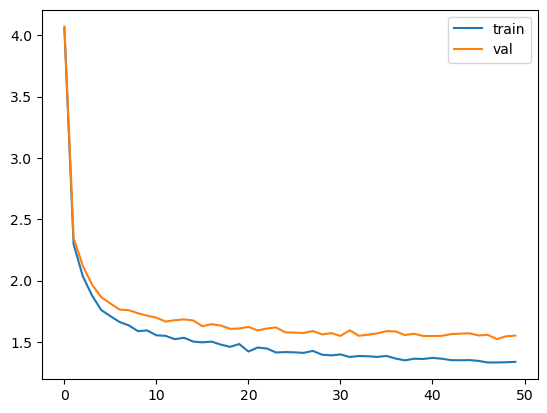

In [70]:
%%time

from datetime import datetime

llama = Llama2(model_config)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, print_logs=True)

# Save
now = datetime.now()
model_name = f'./checkpoint/llama2_L{model_config.n_layers}xH{model_config.n_heads}xC{model_config.max_seq_len}_{now.year}_{now.month}_{now.day}_{now.hour}_{now.minute}.pth'
torch.save({'model_state_dict': llama.state_dict()}, model_name)

## Generate

In [71]:
@torch.no_grad()
def generate(model : Llama2, max_new_tokens = 10):
    model.eval()
    config = model.config
    max_new_tokens = model.config.max_seq_len if max_new_tokens > model.config.max_seq_len else max_new_tokens
    idx = torch.zeros(config.max_batch_size, 1).long()

    start_pos = 0
    for i in range(max_new_tokens):
        if i == 0:
            logits = model(idx)
        else:
            logits = model(idx[:, -1].unsqueeze(-1), start_pos)
            # logits = model(idx[:, -config.max_seq_len:], 0)
        
        last_time_step_logits = logits[:, -1, :]            # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)        # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )                                                   # sample from the distribution to get the next token

        start_pos = idx.shape[-1]
        idx = torch.cat([idx, idx_next], dim=-1)            # append to the sequence
                    
    return [decode(x) for x in idx.tolist()]

In [72]:
import glob
import os

## Get lastest checkpoint
files = glob.glob('./checkpoint/*.pth')
files.sort(key=os.path.getmtime)
model_name = files[-1]

llama_infer = Llama2(model_config)
llama_infer.load_state_dict(torch.load(model_name)['model_state_dict'])

Initialized RoPE with shape torch.Size([128, 16])
model params: 541824


<All keys matched successfully>

In [73]:
%%time

for s in generate(llama_infer, 100):
    print(s)


I have such my pactise all the bundam ag's kin about,
and brist as young and air gates. For soon of 

Of the secret mark afe of my rose were do see,
He's site of lyes!' thou art hate my boys.
O mercy?
S


HASTINGS:
And save I hard so, pay as here 'Hence.

KING HENRY VI:
Had my face-erge: if your breath 

Or ear the repaitors respite.

AEdile:
A mose my all seek'd sorrow me. I am gensing, my hope.

HASTI

Meantime is ours,
Which thee I must night-buildness entertains,
And, he's after to my shrig and this

I will come to see dealm mark, will I warrant,
To pespite soul me: rue is makes, you say me!
So, par

So he house, make will she bad pleasing us
The harms I hate!

EARL OF LIZELOW:
I am rept it would he

May son which to him to sometime ill.
Here in my bried shepherd to shall limposude!
And you go: sch 

DUKE OF AUMERLE:
What thy dead what! you, either-keer Very head,
Nor again to this daughter would I 

Rathers, who show thee my mother sully fearf;
As love, since my blood out but my 